# Part 2 : CNN with pre_trained data : Glove

### Dhiaeddine YOUSFI & Wafa BOUZOUITA

In [1]:
import re
import numpy as np
import torch
import torch.autograd as ag
import torch.nn.functional as F
import torch.nn as nn
import torch.optim.lr_scheduler as lr_sch
import matplotlib.pyplot as plt

import random

## Data

In [2]:
# Tokenize a sentence
def clean_str(string, tolower=True):
    """
    Tokenization/string cleaning.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    if tolower:
        string = string.lower()
    return string.strip()


# reads the content of the file passed as an argument.
# if limit > 0, this function will return only the first "limit" sentences in the file.
def loadTexts(filename, limit=-1):
    f = open(filename)
    dataset=[]
    line =  f.readline()
    cpt=1
    skip=0
    while line :
        cleanline = clean_str(f.readline()).split()
        if cleanline: 
            dataset.append(cleanline)
        else: 
            line = f.readline()
            skip+=1
            continue
        if limit > 0 and cpt >= limit: 
            break
        line = f.readline()
        cpt+=1        
        
    f.close()
    print("Load ", cpt, " lines from ", filename , " / ", skip ," lines discarded")
    return dataset

In [3]:
LIM=5000
txtfile = 'imdb.pos'  # path of the file containing positive reviews
postxt = loadTexts(txtfile,limit=LIM)

txtfile = 'imdb.neg' # path of the file containing negative reviews
negtxt = loadTexts(txtfile,limit=LIM)

Load  5000  lines from  imdb.pos  /  1  lines discarded
Load  5000  lines from  imdb.neg  /  1  lines discarded


In [4]:
txt = postxt + negtxt
label = list(np.ones(LIM, int))+list(np.zeros(LIM, int))

In [5]:
from sklearn.model_selection import train_test_split

txt_train, txt_dev, label_train, label_dev = train_test_split(txt, label, test_size=0.1, random_state=26 ,stratify=label)

txt_train, txt_test, label_train, label_test = train_test_split(txt_train , label_train , test_size=0.1, random_state = 26 , stratify=label_train)

# Converting data to Pytorch tensors

In [6]:
class Dict:
    def __init__(self, words, unk=None):
        self._unk = unk
        self._word_to_id = dict()
        self._id_to_word = list()

        if unk in words:
            raise RuntimeError("UNK word exists in vocabulary")

        if unk is not None:
            self.unk_index = self._add_word(unk)

        for word in words:
            self._add_word(word)

    # for internal use only!
    def _add_word(self, word):
        if word not in self._word_to_id:
            id = len(self._id_to_word)
            self._word_to_id[word] = id
            self._id_to_word.append(word)
            return id
        else:
            return self._word_to_id[word]

    def str_to_id(self, word):
        if self._unk is not None:
            return self._word_to_id.get(word, self.unk_index)
        else:
            return self._word_to_id[word]

    def id_to_str(self, id):
        return self._id_to_word[id]

    def __len__(self):
        return len(self._word_to_id)

    def has_unk(self):
        return self._unk is not None
    
    def unk(self):
        return self.unk_index

In [7]:
#Creating a dictionary where each word is associated to an index
word_index = {}
for sentence in txt_train:
    for word in sentence:
        if word not in word_index:
            word_index[word] = len(word_index) + 1
            

In [8]:
Dict_index = Dict(word_index, unk=True)

## Training loop

In [9]:
def train(model , epochs, X_train ,y_train , X_dev , y_dev , optimizer, lr):   
        
    #variables to see the progression
    mean_loss_train = []
    mean_loss_dev = []
    accuracy_train = []
    accuracy_dev = []
    
    
    #passe le modele en mode training
    model.train()
    
    for i in range(epochs):
        
        #Adaptive learning rate
        if((i+1)%2 == 0):
            for f in optimizer.param_groups:
                f['lr'] = f['lr']*0.75
                
        #defining parameters to print the evolution of the NN
        accuracy = 0
        mean_loss = 0
        
        #shuffle to reduce overfitting
        d = list(zip(X_train, y_train))
        np.random.shuffle(d)
        X_train, y_train = zip(*d)
        
        for sentence,label in zip(X_train , y_train):
            
            # initialize the parameters gradient to zero
            optimizer.zero_grad()
            
            #Creating the tensors for inputs
            data = torch.LongTensor([Dict_index.str_to_id(word) for word in sentence])
            label = torch.Tensor([label])
            #prediction and loss
            prediction = model(data)
            loss_out = loss(prediction , label)
            mean_loss+=loss_out.item()
            
            #Backward and updates
            loss_out.backward()
            optimizer.step()

            #Computing accuracy
            if (prediction >= 0.5 and label==1) or (prediction<0.5 and label==0):
                accuracy += 1
            
        mean_loss_train.append(mean_loss/len(X_train))
        accuracy_train.append(accuracy/len(X_train))
        
        print("EPOCH" , str(i+1) ,"On the training data : mean loss is :" , mean_loss/len(X_train) , "accuracy is: " ,accuracy/len(X_train))


        mean_loss = 0
        accuracy = 0
        
        #testing on dev data
        for sentence,label in zip(X_dev,y_dev):
            data = torch.LongTensor([Dict_index.str_to_id(word) for word in sentence])
            label = torch.Tensor([label])
            
            #prediction and loss
            prediction = model(data)
            loss_out = loss(prediction , label)
            
            mean_loss+=loss_out.item()
            
            
            #computing accuracy
            if (prediction >= 0.5 and label==1) or (prediction < 0.5 and label==0):
                accuracy += 1
            
        print("EPOCH" , str(i+1) ,"On the dev data : mean loss is : " , mean_loss/len(X_dev) , " accuracy is : " ,accuracy/len(X_dev))
        print("----------------------------------------------------------------------------")
        mean_loss_dev.append(mean_loss/len(X_dev))
        accuracy_dev.append(accuracy/len(X_dev))
          
            
            
    #Plotting accuracy curves for dev and train data
    plt.figure()
    plt.plot(accuracy_train , label='Train')
    plt.plot(accuracy_dev, label="Dev")
    plt.title("Accuracy in term of epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    #Plotting loss curves for dev and train data
    plt.figure()    
    plt.plot(mean_loss_train , label='Train')
    plt.plot(mean_loss_dev, label="Dev")
    plt.title("Loss in term of epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    

In [ ]:
#Calculating accuracy on test data
def test_accuracy(model,  X_test , y_test):
    
    accuracy = 0
    mean_loss = 0
        
    for sentence,label in zip(X_test,y_test):
        data = torch.LongTensor([Dict_index.str_to_id(word) for word in sentence])
        label = torch.Tensor([label])
             
        pred = model(data)
        loss_out = loss(pred , label)
        mean_loss += loss_out.item()
                        
            
        #computing accuracy
        if (pred >= 0.5 and label==1) or (pred<0.5 and label==0):
            accuracy += 1

            
    print("Accuracy on test set for this model is" , accuracy/len(X_test))
    return(accuracy/len(X_test))

## CNN with pretrained data 

In [10]:
def reg(inputs,kernel_size):
    
    if(inputs.shape[0]<kernel_size):
        pad = torch.tensor([0 for i in range(kernel_size-inputs.shape[0])])
        inputs = torch.cat((inputs, pad), 0)
    return(inputs)  

def Conv(inputs,kernel_size, conv):
    concat_inp = []
    for i in range(inputs.shape[0]-kernel_size+1):
        Y = [inputs[j] for j in range(i, kernel_size+i)]
        concat = torch.cat(Y, 0)
        concat_inp.append(F.relu(conv(concat)) )
    return(concat_inp)

def Pooling(concat_list,pool_choice):
    
    h_ = torch.stack(concat_list)
    if pool_choice == "max":
        h_, _ = torch.max(h_, 0)
    if pool_choice == "mean":
        h_ = torch.mean(h_, 0)        
    return(h_)

def rec(proj,h,index):
    
    if index == len(proj)-1 :
        return(proj[index](h))
    
    z = torch.tanh(proj[index](h))
    index +=1
    return(rec(proj,z,index))

In [17]:
class CNN_pretrained(nn.Module):
    def __init__(self, vocab_size, weights_matrix, kernel_size, feature_size , pool_choice):
        super(CNN_pretrained, self).__init__()
        
        #Parameters
        self.kernel_size = kernel_size
        self.feature_size = feature_size
        self.pool_choice  = pool_choice        

        #Embedding layer
        self.embeddings, _, embedding_dim = create_emb_layer(torch.tensor(weights_matrix), False)
        
        #Convolution layer
        self.convs = nn.ModuleList([nn.Linear(embedding_dim*kernel_size[i],feature_size[0]) for i in range(len(kernel_size))])
        
        #output projection
        self.projs = nn.ModuleList([nn.Linear(feature_size[0]*len(kernel_size),feature_size[1])]+ 
                                   [nn.Linear(feature_size[i],feature_size[i+1])
                                    for i in range(1,len(feature_size)-1)])
        
        # Parameter initialization  
        for i in range(len(self.projs)):
            nn.init.xavier_uniform_(self.projs[i].weight.data)
            nn.init.zeros_(self.projs[i].bias.data)
            
        #dropout
        #self.dropout = nn.Dropout(p=0.5)  
        
    def forward(self, inputs):
        
        kernel_size = self.kernel_size
        pool_choice = self.pool_choice        
        #prepare the inputs
        inputs = [reg(inputs,kernel_size[i]) for i in range(len(kernel_size))]
        
        #Embending
        inp = [self.embeddings(inputs[i]) for i in range(len(kernel_size))]

        #Conv
        concat_inp = [Conv(inp[i],kernel_size[i], self.convs[i]) for i in range(len(kernel_size))]
        
        #Pooling
        h = [Pooling(concat_inp[i],pool_choice) for i in range(len(kernel_size))]
        
        #Concatenate the two output of convolution layer
        res = torch.cat(h,0)
        
        output = rec(self.projs,res,0)

        return output

Source : https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76

In [12]:
import bcolz
import pickle

In [13]:
words = []
idx = 0
word2idx = {}
glove_path = '.'
vectors = bcolz.carray(np.zeros(1), rootdir=f'{glove_path}/6B.50.dat', mode='w')

with open(f'{glove_path}/glove.6B.50d.txt', 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        words.append(word)
        word2idx[word] = idx
        idx += 1
        vect = np.array(line[1:]).astype(np.float)
        vectors.append(vect)
    
vectors = bcolz.carray(vectors[1:].reshape((400000, 50)), rootdir=f'{glove_path}/6B.50.dat', mode='w')
vectors.flush()
pickle.dump(words, open(f'{glove_path}/6B.50_words.pkl', 'wb'))
pickle.dump(word2idx, open(f'{glove_path}/6B.50_idx.pkl', 'wb'))

In [14]:
vectors = bcolz.open(f'{glove_path}/6B.50.dat')[:]
words = pickle.load(open(f'{glove_path}/6B.50_words.pkl', 'rb'))
word2idx = pickle.load(open(f'{glove_path}/6B.50_idx.pkl', 'rb'))

glove = {w: vectors[word2idx[w]] for w in words}

In [15]:
matrix_len = len(Dict_index)
weights_matrix = np.zeros((matrix_len, 50))
words_found = 0

for i in range (len(Dict_index)):
    try: 
        weights_matrix[i] = glove[Dict_index.id_to_str(i)]
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(50, ))
weights_matrix.shape


(7113, 50)

In [16]:
def create_emb_layer(weights_matrix, non_trainable=False):
    num_embeddings, embedding_dim = weights_matrix.shape
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

EPOCH 1 On the training data : mean loss is : 0.5669661362179108 accuracy is:  0.6632098765432098
EPOCH 1 On the dev data : mean loss is :  0.5035964298445069  accuracy is :  0.766
----------------------------------------------------------------------------
EPOCH 2 On the training data : mean loss is : 0.4412463931192241 accuracy is:  0.7683950617283951
EPOCH 2 On the dev data : mean loss is :  0.4441615254799494  accuracy is :  0.752
----------------------------------------------------------------------------
EPOCH 3 On the training data : mean loss is : 0.3944334196314593 accuracy is:  0.7980246913580247
EPOCH 3 On the dev data : mean loss is :  0.45495784322813415  accuracy is :  0.764
----------------------------------------------------------------------------
EPOCH 4 On the training data : mean loss is : 0.3456728720220883 accuracy is:  0.8317283950617284
EPOCH 4 On the dev data : mean loss is :  0.45203407478633295  accuracy is :  0.75
--------------------------------------------

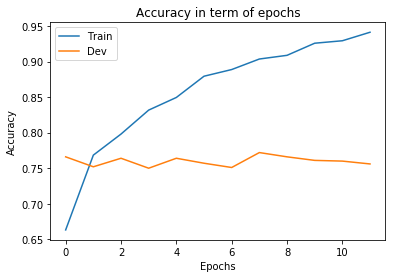

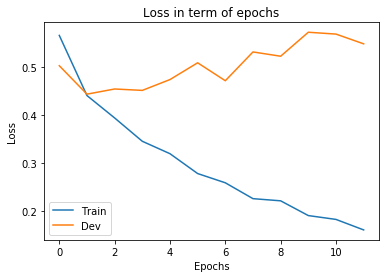

In [19]:
loss = nn.BCEWithLogitsLoss()
model= CNN_pretrained(len(Dict_index), weights_matrix, [3], [5,1], "mean")
optimizer_SGD = torch.optim.SGD(params=model.parameters(), lr=0.1, weight_decay=1e-3)
train(model , 12 ,txt_train ,label_train, txt_dev, label_dev, optimizer_SGD ,0.1)

In [20]:
test_accuracy(model,  txt_test , label_test)

Accuracy on test set for this model is 0.7611111111111111


0.7611111111111111